In [1]:
import os
import pandas as pd
import numpy as np
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import pycountry

atlas_path = "./Vivli Data Challenge 2025 - Nachtrab/ATLAS_Antibiotics/2025_03_11 atlas_antibiotics.xlsx"
atlas_df = pd.read_excel(atlas_path)

cabbage_path = "./CABBAGEdata/processed_database/dereplicated__all_clean.csv"
cabbage_df = pd.read_csv(cabbage_path)

# Only keep the liquid solution typing methods
cabbage_df.drop(cabbage_df[cabbage_df["measurement_unit"] != "mg/l"].index, inplace=True)

antibio_pairs_path = "./generated_data/sorted_species_antibio_pairs.csv"
pairs_df = pd.read_csv(antibio_pairs_path)

/tmp/ipykernel_212849/800659474.py:16: DtypeWarning: Columns (3,10,12,13,14,15,17,18,20,21,22,23,25,26,27,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  cabbage_df = pd.read_csv(cabbage_path)


In [2]:
# Vivli has a single isolate (row) tested on multiple antibio
# Cabbage has a single test on a row, with possibly multiple rows per specimen/id

atlas_data = atlas_df.copy()
cabbage_data = cabbage_df.copy()

# Process data to be ingestible for comparison
cabbage_data["combined_value"] = cabbage_data["measurement_sign"].fillna("") + cabbage_data["measurement_value"].astype(str).fillna("")

cabbage_antibiotics = cabbage_data["Antibiotic_name"].dropna().unique()

for abx in cabbage_antibiotics:
    cabbage_data[abx] = np.nan

for abx in cabbage_antibiotics:
    mask = cabbage_data["Antibiotic_name"] == abx
    cabbage_data.loc[mask, abx] = cabbage_data.loc[mask, "combined_value"]



# Now we handle making the values uniform with the vivli data
for antibiotic in cabbage_antibiotics:
    new_column_name = antibiotic.replace("/", " ")
    if new_column_name == "Trimethoprim sulfamethoxazole":
        new_column_name = "Trimethoprim sulfa"

    cabbage_data[new_column_name] = np.where(cabbage_data["Antibiotic_name"] == antibiotic, 
                                            (cabbage_data["measurement_sign"].fillna('') + cabbage_data["measurement_value"].astype(str)),
                                            np.nan)

# Create a new Species column for cabbage combining genus and species
cabbage_data["combined_species"] = cabbage_data["genus"].astype(str) + " " + cabbage_data["species"]

# Unify sex
cabbage_data['host_sex'] = cabbage_data['host_sex'].replace('male', 1.0)
cabbage_data['host_sex'] = cabbage_data['host_sex'].replace('female', 0.0)

# Encode phenotype. Cabbage has categories: ['susceptible' 'resistant' 'non-susceptible', 'susceptible dose dependent', 'decreased susceptibility']
# Ignore for the moment. Non-susceptible = resistant. Breakpoints change by country, over time, etc
encoder = OrdinalEncoder(categories=[['susceptible', 'intermediate', 'resistant', 'decreased susceptibility', 'susceptible dose dependent', 'non-susceptible']])
mask = cabbage_data['phenotype'].notna()
cabbage_data.loc[mask, 'phenotype_encoded'] = encoder.fit_transform(cabbage_data.loc[mask, ['phenotype']])
cabbage_data['phenotype_encoded'] = cabbage_data['phenotype_encoded'].astype('float')

# Bin ages. Atlas has defined age groups
bins = [0, 2, 12, 18, 64, 84, np.inf]
labels = ["0 to 2 Years", "3 to 12 Years", "13 to 18 Years", 
          "19 to 64 Years", "65 to 84 Years", "85 and Over"]
cabbage_data['Age Group'] = pd.cut(cabbage_data['host_age'], bins=bins, labels=labels, right=True)

# Encode. TODO: different than vivli - change vivli?
age_ordinal = OrdinalEncoder(categories=[labels], 
                            handle_unknown="use_encoded_value",
                            unknown_value=-1,
                            dtype=float)
cabbage_data['Age Group Encoded'] = age_ordinal.fit_transform(cabbage_data[['Age Group']])
cabbage_data['Age Group Encoded'].replace(-1, np.nan, inplace=True)

# Convert Year to numerical.
cabbage_data['collection_date'].astype('float32')





# Encode atlas vivli data into a numerical format

# Handle _I columns, [nan 'Susceptible' 'Intermediate' 'Resistant'] into nan, 0, 1, 2
columns_of_interest = [col for col in atlas_data.columns if col.endswith('_I')]
atlas_antibiotics = [col[:-2] for col in atlas_data.columns]
atlas_data[columns_of_interest] = atlas_data[columns_of_interest].astype("string")

encoder = OrdinalEncoder(categories=[['Susceptible', 'Intermediate', 'Resistant']] * len(columns_of_interest), 
                         handle_unknown="use_encoded_value", unknown_value=np.nan, 
                         dtype=float)
atlas_data[columns_of_interest] = encoder.fit_transform(atlas_data[columns_of_interest])


# Handle age and gender [using nans]
atlas_data['Age Group'] = atlas_data['Age Group'].replace('Unknown', np.nan)
age_ordinal = OrdinalEncoder(categories=[["0 to 2 Years", "3 to 12 Years", "13 to 18 Years", "19 to 64 Years", "65 to 84 Years", "85 and Over"]],
                            handle_unknown="use_encoded_value", unknown_value=np.nan, 
                            dtype=float)

atlas_data["Age Group"] = age_ordinal.fit_transform(atlas_data[["Age Group"]])


# Male 0.0, Female 1.0
atlas_data['Gender'] = atlas_data['Gender'].replace('Unknown', np.nan)
gender_ordinal = OrdinalEncoder(categories=[["Male", "Female"]],
                                handle_unknown="use_encoded_value", unknown_value=np.nan, 
                                dtype=float)
atlas_data["Gender"] = gender_ordinal.fit_transform(atlas_data[["Gender"]])

# Substitue the unknown ranks for nan
atlas_data['Speciality'] = atlas_data['Speciality'].replace("None Given",np.nan)
atlas_data['Speciality'] = atlas_data['Speciality'].replace("Other", np.nan)

atlas_data['In / Out Patient'] = atlas_data['In / Out Patient'].replace('None Given', np.nan)
atlas_data['In / Out Patient'] = atlas_data['In / Out Patient'].replace('Other', np.nan)

# Convert Year to numerical. Corresponds to Cabbage "collection_date"
atlas_data['Year'].astype('float32')

# Convert country to Alpha 3
atlas_data["country_alpha3"] = atlas_data["Country"].apply(
    lambda x: pycountry.countries.lookup(x).alpha_3 if isinstance(x, str) and pycountry.countries.get(name=x) else None
)




# Get common bacteria and antibiotics
overlapping_bacteria = [s.lower() for s in list(set(cabbage_data["combined_species"].unique()) & set(atlas_data["Species"].unique()))]

print(f"overlapping_bacteria length: {len(overlapping_bacteria)}, cabbage species: {len(cabbage_data["combined_species"].unique())}, atlas species: {len(atlas_data["Species"].unique())}")


overlapping_antibio = [s.lower() for s in list(set(cabbage_antibiotics) & set(atlas_antibiotics))]
print(f"overlapping_antibio length: {len(overlapping_antibio)}")


/tmp/ipykernel_212849/698610180.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cabbage_data[abx] = np.nan
/tmp/ipykernel_212849/698610180.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cabbage_data[abx] = np.nan
/tmp/ipykernel_212849/698610180.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

overlapping_bacteria length: 29, cabbage species: 54, atlas species: 390
overlapping_antibio length: 36


In [3]:
def print_yoy_data(analysis_df, species, antibiotic, location=None):
    """
    Print the year over year data present in an ATLAS dataframe
    """        
    antibiotic_column_name = next(col for col in analysis_df.columns if col.lower() == antibiotic.lower())

    external_subset = analysis_df[analysis_df["Species"].str.lower() == species.lower()]
    internal_subset = analysis_df[analysis_df["Species"].str.lower() == species.lower()]
    if location:
        internal_subset = internal_subset[internal_subset["country_alpha3"].str.lower() == location.lower()]
        external_subset = external_subset[external_subset["country_alpha3"].str.lower() == location.lower()]

    internal_subset = internal_subset.dropna(subset=[antibiotic_column_name])
    external_subset = external_subset.dropna(subset=[antibiotic_column_name])
    print(f"For country: {location}")
    for i in range(2000, 2026):
        print(f"Year: {i}, nb: {(internal_subset["Year"] == i).sum()}")

In [4]:
print(pairs_df.info())
pd.set_option('display.max_rows', None)  
pairs_df.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  170 non-null    int64  
 1   species     170 non-null    object 
 2   antibiotic  170 non-null    object 
 3   n_atlas     170 non-null    int64  
 4   n_cabbage   170 non-null    int64  
 5   score       170 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 8.1+ KB
None


,Unnamed: 0,species,antibiotic,n_atlas,n_cabbage,score
0,0,escherichia coli,ampicillin,119898,11081,20287.064919
1,1,escherichia coli,gentamicin,39555,13590,20229.652837
2,2,escherichia coli,meropenem,111805,11044,20102.311293
3,3,streptococcus pneumoniae,penicillin,48017,12438,19758.016574
4,4,escherichia coli,ciprofloxacin,39554,12320,18788.035625
5,5,escherichia coli,ceftazidime,93167,9477,17203.999435
6,6,escherichia coli,ceftriaxone,62761,9927,17142.539264
7,7,escherichia coli,amikacin,119898,9150,17002.459550
8,8,escherichia coli,imipenem,75358,7383,13448.426149
9,9,streptococcus pneumoniae,erythromycin,45922,7230,12493.078718


Year: 2013, %: 60.26058631921825
Year: 2017, %: 58.17805383022774
Year: 2021, %: 51.674641148325364
{np.float64(64.0), np.float64(0.5), np.float64(2.0), np.float64(32.0), np.float64(4.0), np.float64(1.0), np.float64(8.0), np.float64(16.0)}
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
Year_2017  0.136764   1.146558  0.091193       -0.041971        0.315499   
Year_2021  0.234305   1.264030  0.114340        0.010203        0.458408   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
Year_2017             0.958898             1.370943     0.0  1.499721   
Year_2021             1.010255             1.581553     0.0  2.049195   

                  p  -log2(p)  
covariate                      
Year_2017  0.133687  2.903071  
Year_2021  0.040443  4.627963  

   Bootstrapping lowess lines. Ma

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1306 total observations, 714 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic      p  -log2(p)
Year_2017 km              0.04   0.83      0.27
          rank           41.27 <0.005     32.81
Year_2021 km             14.08 <0.005     12.48
          rank          127.44 <0.005     95.76



1. Variable 'Year_2017' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Year_2017', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Year_2021' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Year_2021', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assump

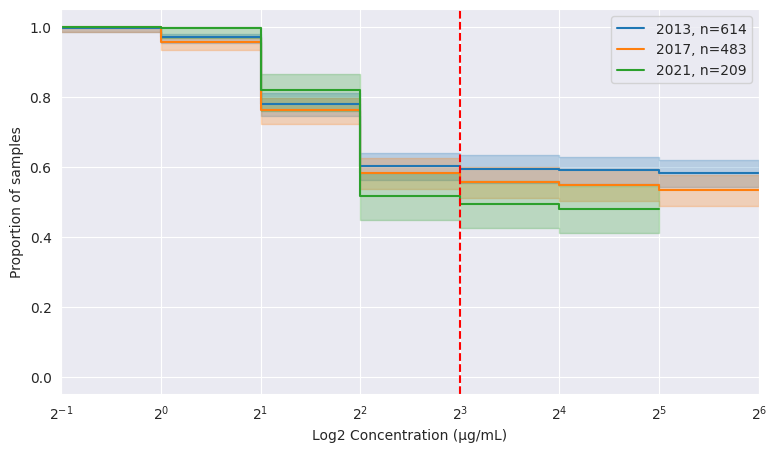

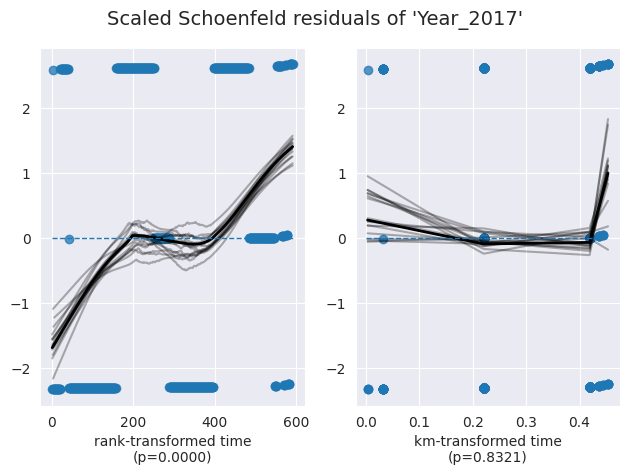

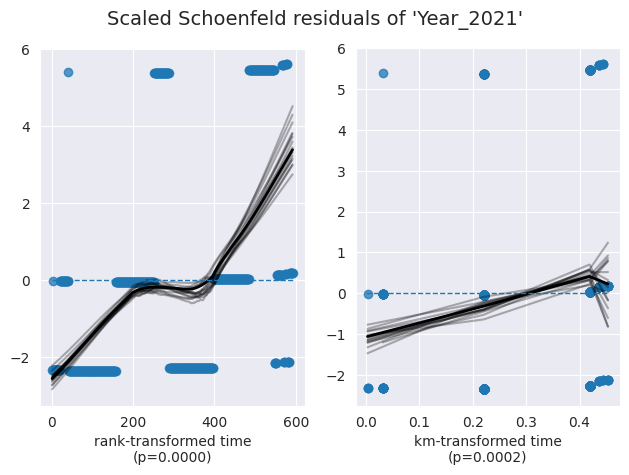

In [7]:
# Report graphs
import seaborn as sns
import scipy

# Parse value for Left truncated (late entry) data
# https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html#left-truncated-late-entry-data
def parse_value(val):
    """
    Parse str '<=2', '>8', '2/32', '=0.5', '16' into (lower, upper) for censoring.
    Returns: lower bound, upper bound, observed
    """
    if pd.isna(val):
        return (np.nan, np.nan, np.nan)
    
    val = str(val).strip()
    
    # To check -> removed
    # Intevals happen when there is ambiguity
    if val.startswith(">,<"):
        val = val[3:].split(",")
        return (float(val[0]), float(val[1]), True)
    
    # Has been normalized too
    # Right censoring
    if val.startswith(">="):
        return (float(val[2:]), float(val[2:]), True)
    
    elif val.startswith(">"):
        return (float(val[1:]), float(val[1:])*2, False)
    
    # <= and < are in practice observed the same way. So both false.
    elif val.startswith("<="):
        return (0.0, float(val[2:]), True)
    
    elif val.startswith("<"):
        return (0.0, float(val[1:]), False)
    
    elif val.startswith("="):
        v = float(val[1:])
        return (v, v, True) # Upper value inf? Or v?
    
    # Just straight up numbers
    else:
        try:
            v = float(val)
            return (v, v, True)
        except ValueError:
            return (np.nan, np.nan, np.nan)


def generate_internal_comparison(anal_atlas_df, species, antibiotic, years, location=None, gender=None):
    """
    Compare a dataset amongst itself, stratified on parameters
    """

    internal_subset = anal_atlas_df[anal_atlas_df["Species"].str.lower() == species.lower()]
   
    if location:
        internal_subset = internal_subset[internal_subset["country_alpha3"].str.lower() == location.lower()]

    internal_subsets = {}
    for year in years:
        internal_subsets[year] = internal_subset[internal_subset["Year"] == year]

    atlas_col = next(col for col in anal_atlas_df.columns if col.lower() == antibiotic.lower())
    

    min_val = 0
    max_val = 0
    percentage_resistant = {}
    unique_x_vals = set()
    # Drop NaNs 
    for year_key in internal_subsets:
        internal_subsets[year_key] = internal_subsets[year_key].dropna(subset=[atlas_col])

        # Apply parse_value and expand into new columns
        internal_subsets[year_key] = internal_subsets[year_key][["T_lower", "T_upper", "T_observed"]] = internal_subsets[year_key] = internal_subsets[year_key][atlas_col].apply(
            lambda x: pd.Series(parse_value(x))
        )

        unique_x_vals.update(internal_subsets[year_key]["T_upper"].unique())

        internal_high = internal_subsets[year_key]["T_upper"].max()
        if internal_high > max_val:
            max_val = internal_high

        percentage_resistant[year_key] = (((internal_subsets[year_key]["T_upper"] >= 8.0).sum())
                                          /len(internal_subsets[year_key]["T_upper"])
                                          )*100
        print(f"Year: {year_key}, %: {percentage_resistant[year_key]}")

    
    fig, ax = plt.subplots(figsize=(9, 5))

    ax.set_xlim(min(unique_x_vals), max(unique_x_vals))
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale('log', base=2)
    print(unique_x_vals)
    ax.set_xticks(np.sort(np.array(list(unique_x_vals))))

    for year_key in internal_subsets:
        sub = internal_subsets[year_key]

        kmf_int = KaplanMeierFitter()

        kmf_int.fit(sub["T_upper"], event_observed=sub["T_observed"], label=f"{year_key}, n={len(sub)}")
        kmf_int.plot_survival_function(ax=ax)

    plt.axvline(x = 8.0, ymin = 0, ymax = 1.0, linestyle ="--", color ='red', label="EUCAST Breakpoint, 2021")
    plt.ylabel("Proportion of samples")
    plt.xlabel("Log2 Concentration (μg/mL)")




    # ---- Cox PH model across years ----
    ref_year = years[0]

    # Combine all years into one modeling dataframe
    model_df = []
    for year_key, sub in internal_subsets.items():
        if len(sub):
            m = sub[["T_upper","T_observed"]].copy()
            m["Year"] = year_key
            model_df.append(m)
    if not model_df:
        raise ValueError("No rows to fit the Cox model after filtering.")
    
    model_df = pd.concat(model_df, ignore_index=True)


    # Encode Year as categorical with a reference
    model_df["Year"] = pd.Categorical(model_df["Year"], categories=years, ordered=False)
    X = pd.get_dummies(model_df["Year"], prefix="Year", drop_first=True)

    # If you want a specific reference year, reorder categories so it is first:
    if ref_year in years and years[0] != ref_year:
        years_ordered = [ref_year] + [y for y in years if y != ref_year]
        model_df["Year"] = pd.Categorical(model_df["Year"], categories=years_ordered, ordered=False)
        X = pd.get_dummies(model_df["Year"], prefix="Year", drop_first=True)

    # Assemble dataset for lifelines
    cox_df = pd.concat([model_df[["T_upper","T_observed"]].reset_index(drop=True), X.reset_index(drop=True)], axis=1)

    # Fit Cox PH
    cph = CoxPHFitter()
    cph.fit(cox_df, duration_col="T_upper", event_col="T_observed")
    print(cph.summary)

    # Global test: do years matter overall?
    # lifelines exposes the log-likelihood ratio test on the fitted model:
    # (attribute name includes a trailing underscore in many versions)
    try:
        llrt = cph.log_likelihood_ratio_test_
        print(f"\nGlobal LLR test for Year terms: chi2={llrt.test_statistic:.3f}, df={llrt.degrees_freedom}, p={llrt.p_value:.4g}")
    except Exception:
        pass

    # Optional: check proportional hazards assumption (prints diagnostics)
    cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=True)



    return None


sns.set_style("darkgrid")  # Or "darkgrid", "ticks", etc.
# print_yoy_data(atlas_data, "escherichia coli", "ampicillin", location="FRA")
generate_internal_comparison(atlas_data, "escherichia coli", "ampicillin", years=[2013,2017,2021], location="DEU")


26094
7583
[nan '=1' '<=2' '>16' '=4' '=16' '=8' '<=0.5' '=2' '=0.5' '<=1' '>=16'
 '0.5' '32' '1' '8' '2' '>32' '64' '4' '>4' '>256']


/tmp/ipykernel_212849/1412724599.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  atlas_sub[["T_lower", "T_upper", "T_observed"]] = atlas_sub[atlas_col].apply(
/tmp/ipykernel_212849/1412724599.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  atlas_sub[["T_lower", "T_upper", "T_observed"]] = atlas_sub[atlas_col].apply(
/tmp/ipykernel_212849/1412724599.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

Unique Atl vals: [ 1.    0.5  32.    2.    0.25 16.    0.12  4.    8.  ]
Unique Cab vals: [1.00e+00 2.00e+00 3.20e+01 4.00e+00 1.60e+01 8.00e+00 5.00e-01 6.40e+01
 5.12e+02]
(np.float64(0.0992431640625), np.float64(0.11518324607329843))


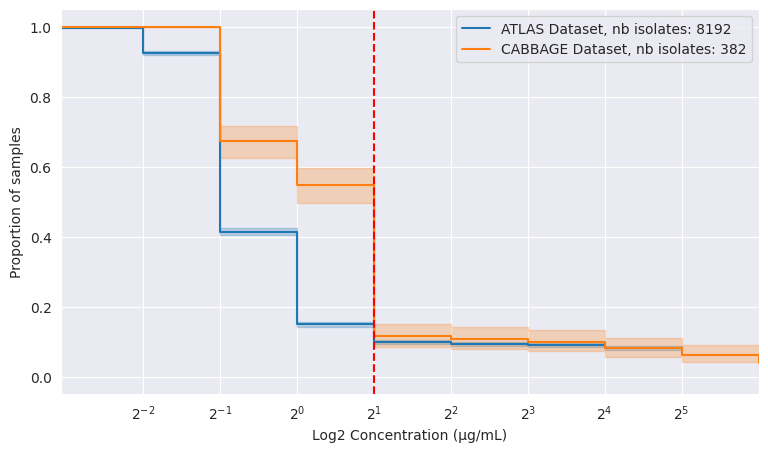

In [8]:

def generate_atlas_cabbage_comparison(atlas_dataset, cabbage_dataset, species, antibiotic, year_from_to, locations=None, gender=None):
    """
    Compare two datasets
    """

    atlas_sub = atlas_dataset[atlas_dataset["Species"].str.lower() == species.lower()]
    cabbage_sub = cabbage_dataset[cabbage_dataset["combined_species"].str.lower() == species.lower()]

    atlas_sub = atlas_sub[atlas_sub["country_alpha3"].isin(locations)]
    cabbage_sub = cabbage_sub[cabbage_sub["isolation_country"].isin(locations)]

    y_from, y_to = year_from_to
    atlas_sub = atlas_sub[(atlas_sub["Year"] >= y_from) & (atlas_sub["Year"] <= y_to)]
    cabbage_sub = cabbage_sub[(cabbage_sub["collection_date"] >= y_from) & (cabbage_sub["collection_date"] <= y_to)]

    atlas_col = next(col for col in atlas_dataset.columns if col.lower() == antibiotic.lower())
    cabbage_col = next(col for col in cabbage_dataset.columns if col.lower() == antibiotic.lower())    

    print(len(atlas_sub))
    print(len(cabbage_sub))

    # print((cabbage_sub[["combined_species",cabbage_col]]).unique())
    print((cabbage_sub[cabbage_col]).unique())

    min_val = 0
    max_val = 0
    percentage_resistant = {}
    # unique_x_vals = set()
    
    
    # Drop NaNs 
    atlas_sub = atlas_sub.dropna(subset=[atlas_col])
    cabbage_sub = cabbage_sub.dropna(subset=[cabbage_col])

    # Apply parse_value and expand into new columns
    atlas_sub[["T_lower", "T_upper", "T_observed"]] = atlas_sub[atlas_col].apply(
        lambda x: pd.Series(parse_value(x))
    )

    cabbage_sub[["T_lower", "T_upper", "T_observed"]] = cabbage_sub[cabbage_col].apply(
        lambda x: pd.Series(parse_value(x))
    )


    unique_x_atlas_vals = (atlas_sub["T_upper"].unique())
    unique_x_cabbage_vals = (cabbage_sub["T_upper"].unique())


    internal_high = max(unique_x_atlas_vals.max(), unique_x_cabbage_vals.max())
    internal_low = min(unique_x_atlas_vals.min(), unique_x_cabbage_vals.min())


    # percentage_resistant[year_key] = (((internal_subsets[year_key]["T_upper"] >= 8.0).sum())
    #                                     /len(internal_subsets[year_key]["T_upper"])
    #                                     )*100
    # print(f"Year: {year_key}, %: {percentage_resistant[year_key]}")

    
    fig, ax = plt.subplots(figsize=(9, 5))

    # ax.set_xlim(internal_low, internal_high)
    ax.set_xlim(internal_low, 64.1)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale('log', base=2)

    print(f"Unique Atl vals: {unique_x_atlas_vals}")
    print(f"Unique Cab vals: {unique_x_cabbage_vals}")


    ax.set_xticks(np.sort(np.array(list(unique_x_atlas_vals))))


    kmf_int = KaplanMeierFitter()
    kmf_ext = KaplanMeierFitter()

    kmf_int.fit(atlas_sub["T_upper"], event_observed=atlas_sub["T_observed"], label=f"ATLAS Dataset, nb isolates: {len(atlas_sub)}")
    kmf_int.plot_survival_function(ax=ax)

    kmf_ext.fit(cabbage_sub["T_upper"], event_observed=cabbage_sub["T_observed"], label=f"CABBAGE Dataset, nb isolates: {len(cabbage_sub)}")
    kmf_ext.plot_survival_function(ax=ax)

    
    plt.axvline(x = 2.0, ymin = 0, ymax = 1.0, linestyle ="--", color ='red', label="EUCAST Breakpoint, 2021")
    plt.ylabel("Proportion of samples")
    plt.xlabel("Log2 Concentration (μg/mL)")
    

    atlas_count_above_8 = (atlas_sub["T_upper"] > 2.0).sum()
    cabbage_count_above_8 = (cabbage_sub["T_upper"] > 2.0).sum()
    return (atlas_count_above_8/len(atlas_sub["T_upper"]), cabbage_count_above_8/len(cabbage_sub["T_upper"]))


sns.set_style("darkgrid")  # Or "darkgrid", "ticks", etc.

# Meropenem, gentamicin
ret = generate_atlas_cabbage_comparison(atlas_data, cabbage_data, "escherichia coli", "gentamicin", year_from_to=(2013,2021), locations=("AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA",
                                                                                                                   "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD",
                                                                                                                     "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"))
print(ret)